<a href="https://colab.research.google.com/github/beatriz0freitas/PL/blob/main/PL_NB03_Lexical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NB03: Lexical Analysis

## Language Processing

## LEI/2025-26

#### Nuno Macedo
Universidade do Minho



# 3.1 Lexical Analysis

- Lexical analysis is the first step of the language processing pipeline

- It converts a sequence of symbols (input text) into a sequence of *tokens*, contiguous sequences of symbols that are assigned a "type"

- It may also discard some syntactically irrelevant symbols (such as spacing)

- This is the only phase that processes the input at the character level
  - It must be very efficient (based on regular languages)
  - Stores traceability information for error messages (line, column)

  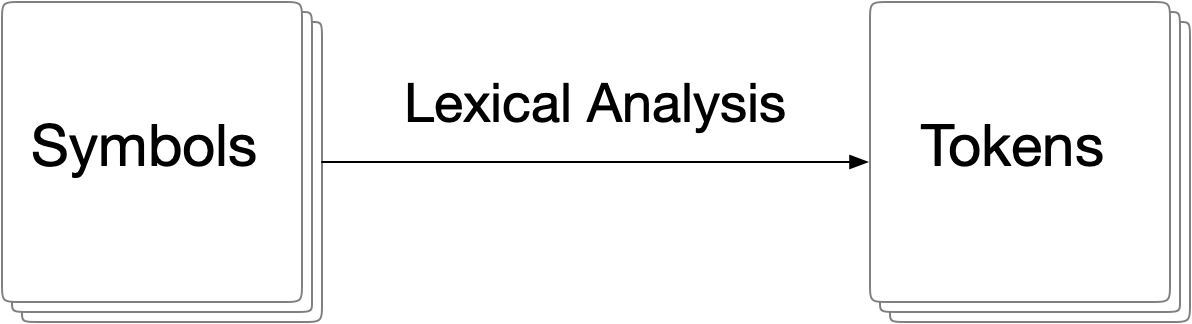

## Tokens

- A *token* is the fundamental unit in the syntactic analysis (next phase of the pipeline)

- Each token has:
  - A token *name*, that denotes its category
  - An optional *attribute* (or *value*) that stores additional information

- Operators and keywords usually have a fixed *lexeme*

- But others (e.g., identifiers or integer literals) do not, they are variable tokens
  - Their shape is defined by a pattern (regular expression)
  - The *lexeme* associated with a token is stored as an attribute

- Another typical attribute is the lexeme position in the original text, useful for error reporting and debugging

## Tokenization Example: Heterogenous lists

```
[ John, 10, 20, Jane, 30, 40 ]
```

- Here there are 5 token categories:
  - delimiters `LPAREN`, `RPAREN` and `COMMA`
  - variable tokens `IDEN` and `INT`

- Result of the tokenization:

  ```
  LPAREN, IDEN(John), COMMA, INT(10), COMMA, INT(20), IDEN(Jane), COMMA, INT(30), COMMA, INT(40), RPAREN
  ```

- Only variable tokens need to store the lexeme

- Spaces have been removed in the process



## Tokenization Example: Shopping lists with categories

```
* Produce
Apples (or pears)
Potatoes
* Bakery
Bread (*the good kind)
Muffins
```

- Here there are 2 token categories:
  - `HEADER` and `TEXT`, both variable

- Result of the tokenization:

  ```
  HEADER(Produce), TEXT(Apples (or pears)), TEXT(Potatoes), HEADER(Bakery), TEXT(Bread (*the good kind)), TEXT(Muffins)
  ```
- New lines have been removed in the process, but not spaces


## Tokenization Example: Arithmetic expressions

```
let x = 5;
let y = 10;
10 * (x + 4) / y
```

- Here there are 11 token categories:
  - keyword `LET`
  - delimiters `LPAREN`, `RPAREN` and `SCOLON`
  - operators `ADD`, `SUB`, `MUL`, `DIV` and `EQ`
  - variable tokens `IDEN` and `INT`

- Result of the tokenization:

  ```
  LET, IDEN(x), EQ, INT(5), SCOLON, LET, IDEN(y), EQ, INT(10), SCOLON, IN(10), MUL, LPAREN, IDEN(x), ADD, INT(4), DIV, IDEN(y)
  ```

- Only variable tokens store the lexeme

- Spaces and new lines have been removed in the process



⚠️ There are many different ways to tokenize the same text, and this decision affects the syntactic analysis phase that follows. For instance, we could have a single token category `OP` for operators, and store the concrete operator as an attribute.

# 3.2 Token Recognition

## Token patterns

- Since not all tokens have fixed lexemes, we need a mechanism to define the pattern that defines each token

- This must be a very efficient process, to process input texts with thousands of symbols

- This is where *regular expressions* come in, as a way to define and efficiently recognize lexemes

- A token category is described by a regular expression

- We have already seen regular expressions to recognize identifiers, integer numbers, floating point numbers, or string literals

## From token patterns to token recognition

- Token patterns describe the set of valid character sequences for each token kind

- During lexical analysis, the input is processed from left to right, and tokens are recognized incrementally

- Once a token category is selected, characters are consumed as long as the current prefix is compatible with the corresponding pattern

- The token is completed as soon as reading one more character would make it invalid

## Building the master regular expression

- In general, a lexical analyzer uses a "master" regular expression built from the alternative of the patterns for each token type

- Different token categories may accept the same character sequences, a recognized lexeme may correspond to more than one token category

- Typical case: reserved keywords that are also valid identifiers
  - In the example above, lexeme `let` is classified as the a keyword token `LET`, but also matches the identifier token `IDEN`

- The lexical analyzer must apply a consistent classification policy when assigning a token category to a recognized lexeme

## Building a lexical analyzer

- Besides the tokens that will be fed to the syntactic analysis phase, we also need to identify tokens that will be discarded (e.g., spacing or comments)

- We can create a simple lexical analyser by using a regular expression processor and named capturing groups to distinguish the token names

- Then we iterate over every match, and identify which group captured the lexeme

In [ ]:
import re

### Manual Analyzer Example: Heterogenous lists

In [ ]:
def tokenize(text):
  regex = r"(?P<INT>\d+)|(?P<IDEN>\w+)|(?P<LPAREN>\[)|(?P<RPAREN>\])|(?P<COMMA>,)|(?P<SKIP>\s+)"
  recognized = []
  for mtch in re.finditer(regex,text):
    if mtch.groupdict()['IDEN']:
      token = ("IDEN", mtch.groupdict()['IDEN'], mtch.span())
    elif mtch.groupdict()['INT']:
      token = ("INT", mtch.groupdict()['INT'], mtch.span())
    elif mtch.groupdict()['COMMA']:
      token = ("COMMA", mtch.span())
    elif mtch.groupdict()['LPAREN']:
      token = ("LPAREN", mtch.span())
    elif mtch.groupdict()['RPAREN']:
      token = ("RPAREN", mtch.span())
    elif mtch.groupdict()['SKIP']:
      token = ("SKIP", mtch.span())
    if token[0] != "SKIP":
      recognized.append(token)
  return recognized

text = "[ John, 10, 20, Jane, 30, 40 ]"
tokens = tokenize(text)
print("\n".join(str(t) for t in tokens))

('LPAREN', (0, 1))
('IDEN', 'John', (2, 6))
('COMMA', (6, 7))
('INT', '10', (8, 10))
('COMMA', (10, 11))
('INT', '20', (12, 14))
('COMMA', (14, 15))
('IDEN', 'Jane', (16, 20))
('COMMA', (20, 21))
('INT', '30', (22, 24))
('COMMA', (24, 25))
('INT', '40', (26, 28))
('RPAREN', (29, 30))


### Traceability

- For traceability purposes, lexical analysis must keep track of the position of each token in the input

- Typically achieved by maintaining line and column counters while scanning the character stream
  - Newlines are always recognized by the lexical analyzer, even when they are not emitted as tokens
  - The same applies to spacing symbols
  
- Note, however, that some languages give a syntactic role to spacing and newlines (e.g., Python)
  - In these cases, they become part of the token stream


### Manual Analyzer Example: Shopping lists with categories

In [ ]:
def tokenize(text):
  regex = r"(?P<HEADER>\*\s+([^\n]*))|(?P<TEXT>[^\n]+)|(?P<SKIP>\n+)"
  recognized = []
  for i, line in enumerate(text):
    # order matters, HEADER lexemes also match the TEXT pattern
    for mtch in re.finditer(regex,line):
      if mtch.groupdict()['HEADER']:
        token = ("HEADER", mtch.group(2), i, mtch.span())
      elif mtch.groupdict()['TEXT'] != None:
        token = ("TEXT", mtch.groupdict()['TEXT'], i, mtch.span())
      elif mtch.groupdict()['SKIP']:
        token = ("SKIP", i, mtch.span())
      if token[0] != "SKIP":
        recognized.append(token)
  return recognized

text = """* Produce
Apples (or pears)
Potatoes
* Bakery
Bread (*the good kind)
Muffins"""
tokens = tokenize(text.splitlines())
print("\n".join(str(t) for t in tokens))

('HEADER', 'Produce', 0, (0, 9))
('TEXT', 'Apples (or pears)', 1, (0, 17))
('TEXT', 'Potatoes', 2, (0, 8))
('HEADER', 'Bakery', 3, (0, 8))
('TEXT', 'Bread (*the good kind)', 4, (0, 22))
('TEXT', 'Muffins', 5, (0, 7))


### Lexical errors

- Some errors are lexical, and can be identified during lexical analysis before the syntactic analysis begins

- Typical lexical errors include:
  - Invalid symbols
  - Unterminated string literal (`"hello`)
  - Malformed number (`12.3.4`)

- Many ways to handle them:
  - Immediatly throw an error
  - Register the error, but proceed with the tokenization
    - Then fail, or let the parser handle error tokens in the next phase

### Manual Analyzer Example: Arithmetic expressions

In [ ]:
def tokenize(text):
  regex = r"(?P<LET>let)|(?P<INT>\d+)|(?P<IDEN>\w+)|(?P<ADD>\+)|(?P<SUB>-)|(?P<MUL>\*)|(?P<DIV>/)|(?P<LPAREN>\()|(?P<RPAREN>\))|(?P<EQ>=)|(?P<SCOLON>;)|(?P<SKIP>\s+)|(?P<UNKNOWN>.)"
  recognized = []
  errors = []
  for i, line in enumerate(text):
    for mtch in re.finditer(regex,line):
      if mtch.groupdict()['LET']:
        token = ("LET", i, mtch.span())
      elif mtch.groupdict()['IDEN']:
        token = ("IDEN", i, mtch.groupdict()['IDEN'], mtch.span())
      elif mtch.groupdict()['INT']:
        token = ("INT", i, mtch.groupdict()['INT'], mtch.span())
      elif mtch.groupdict()['ADD']:
        token = ("ADD", i, mtch.span())
      elif mtch.groupdict()['SUB']:
        token = ("SUB", i, mtch.span())
      elif mtch.groupdict()['MUL']:
        token = ("MUL", i, mtch.span())
      elif mtch.groupdict()['DIV']:
        token = ("DIV", i, mtch.span())
      elif mtch.groupdict()['EQ']:
        token = ("EQ", i, mtch.span())
      elif mtch.groupdict()['LPAREN']:
        token = ("LPAREN", i, mtch.span())
      elif mtch.groupdict()['RPAREN']:
        token = ("RPAREN", i, mtch.span())
      elif mtch.groupdict()['SCOLON']:
        token = ("SCOLON", i, mtch.span())
      elif mtch.groupdict()['SKIP']:
        token = ("SKIP", i, mtch.span())
      elif mtch.groupdict()['UNKNOWN']:
        token = ("UNKNOWN", mtch.groupdict()['UNKNOWN'], i, mtch.span())
      if token[0] != "SKIP":
        if token[0] == "UNKNOWN":
          errors.append(token)
        else:
          recognized.append(token)
  return recognized, errors

In [ ]:
text = """let x = 5;
let y = 10;
10 * (x + 4) / y"""
tokens, errors = tokenize(text.splitlines())
if errors:
  print("* ERRORS")
  print("\n".join(str(t) for t in errors))
print("* TOKENS")
print("\n".join(str(t) for t in tokens))


* TOKENS
('LET', 0, (0, 3))
('IDEN', 0, 'x', (4, 5))
('EQ', 0, (6, 7))
('INT', 0, '5', (8, 9))
('SCOLON', 0, (9, 10))
('LET', 1, (0, 3))
('IDEN', 1, 'y', (4, 5))
('EQ', 1, (6, 7))
('INT', 1, '10', (8, 10))
('SCOLON', 1, (10, 11))
('INT', 2, '10', (0, 2))
('MUL', 2, (3, 4))
('LPAREN', 2, (5, 6))
('IDEN', 2, 'x', (6, 7))
('ADD', 2, (8, 9))
('INT', 2, '4', (10, 11))
('RPAREN', 2, (11, 12))
('DIV', 2, (13, 14))
('IDEN', 2, 'y', (15, 16))


In [ ]:
text = """let x = 5;
let y = 10;
10 * (x + 4) % y"""
tokens, errors = tokenize(text.splitlines())
if errors:
  print("* ERRORS")
  print("\n".join(str(t) for t in errors))
print("* TOKENS")
print("\n".join(str(t) for t in tokens))

* ERRORS
('UNKNOWN', '%', 2, (13, 14))
* TOKENS
('LET', 0, (0, 3))
('IDEN', 0, 'x', (4, 5))
('EQ', 0, (6, 7))
('INT', 0, '5', (8, 9))
('SCOLON', 0, (9, 10))
('LET', 1, (0, 3))
('IDEN', 1, 'y', (4, 5))
('EQ', 1, (6, 7))
('INT', 1, '10', (8, 10))
('SCOLON', 1, (10, 11))
('INT', 2, '10', (0, 2))
('MUL', 2, (3, 4))
('LPAREN', 2, (5, 6))
('IDEN', 2, 'x', (6, 7))
('ADD', 2, (8, 9))
('INT', 2, '4', (10, 11))
('RPAREN', 2, (11, 12))
('IDEN', 2, 'y', (15, 16))


## Generalizing the lexical analysis

- A lexical analyzer follows a common high-level organization, independently of the language being processed

- For a given language, we need to identify:
  - the token kinds
  - the patterns describing valid lexemes for each category

- We assume a special token name (`SKIP`) for symbols to be ignored

- When a lexeme is compatible with multiple categories, the lexical analyzer must apply a consistent convention
  - For now, we assume the convention is based on the order in which token categories are defined

- In practice, other aspects are often handled by lexical analyzers, which we will ignore for now:
  - distinguishing between fixed and variable tokens
  - customizing the information stored for each token

### First version: a parametrizable lexical analyzer

- Let us provide the analyzer with a dictionary of tokens, and generate the master pattern from it


In [ ]:
def tokenize(token_dict, text):
  regex = ("|".join(f"(?P<{token}>{pattern})" for token, pattern in token_dict.items()))+"|(?P<UNKNOWN>.)"
  errors = []
  recognized = []
  for i, line in enumerate(text):
    for mtch in re.finditer(regex,line):
      for k,v in mtch.groupdict().items():
        if v != None:
          token = (k, v, i, mtch.span())
          break

      if token[0] != "SKIP":
        if token[0] == "UNKNOWN":
          errors.append(token)
        else:
          recognized.append(token)
  return recognized, errors

In [ ]:
def process(tokens, text):
  tokens, errors = tokenize(tokens, text.splitlines())
  if errors:
    print("* ERRORS")
    print("\n".join(str(t) for t in errors))
  print("* TOKENS")
  print("\n".join(str(t) for t in tokens))

### Analyzer Generator Example: Heterogenous lists

In [ ]:
tokens = {
    "INT": r"\d+",
    "IDEN": r"\w+",
    "LPAREN": r"\[",
    "RPAREN": r"\]",
    "COMMA": r",",
    "SKIP": r"\s+"
}

text = "[ John, 10, 20, Jane, 30, 40 ]"

process(tokens, text)

* TOKENS
('LPAREN', '[', 0, (0, 1))
('IDEN', 'John', 0, (2, 6))
('COMMA', ',', 0, (6, 7))
('INT', '10', 0, (8, 10))
('COMMA', ',', 0, (10, 11))
('INT', '20', 0, (12, 14))
('COMMA', ',', 0, (14, 15))
('IDEN', 'Jane', 0, (16, 20))
('COMMA', ',', 0, (20, 21))
('INT', '30', 0, (22, 24))
('COMMA', ',', 0, (24, 25))
('INT', '40', 0, (26, 28))
('RPAREN', ']', 0, (29, 30))


### Analyzer Generator Example: Arithmetic expressions

In [ ]:
tokens = {
    "LET": r"let",
    "INT": r"\d+",
    "IDEN": r"\w+",
    "LPAREN": r"\(",
    "RPAREN": r"\)",
    "EQ": r"=",
    "SCOLON": r";",
    "ADD": r"\+",
    "SUB": r"-",
    "MUL": r"\*",
    "DIV": r"/",
    "SKIP": r"\s+"
}

text = """let x = 5;
let y = 10;
10 * (x + 4) % y"""

process(tokens, text)

* ERRORS
('UNKNOWN', '%', 2, (13, 14))
* TOKENS
('LET', 'let', 0, (0, 3))
('IDEN', 'x', 0, (4, 5))
('EQ', '=', 0, (6, 7))
('INT', '5', 0, (8, 9))
('SCOLON', ';', 0, (9, 10))
('LET', 'let', 1, (0, 3))
('IDEN', 'y', 1, (4, 5))
('EQ', '=', 1, (6, 7))
('INT', '10', 1, (8, 10))
('SCOLON', ';', 1, (10, 11))
('INT', '10', 2, (0, 2))
('MUL', '*', 2, (3, 4))
('LPAREN', '(', 2, (5, 6))
('IDEN', 'x', 2, (6, 7))
('ADD', '+', 2, (8, 9))
('INT', '4', 2, (10, 11))
('RPAREN', ')', 2, (11, 12))
('IDEN', 'y', 2, (15, 16))


### Second version: a proper, standalone lexical analyzer

- To promote performance and modularity, lexical analyzers are usually standalone programs

- Let us generate a lexical analyzer from a dictionary of tokens


In [ ]:
def generator(token_dict):

  regex = ("|".join(f"(?P<{token}>{pattern})" for token, pattern in token_dict.items()))+"|(?P<UNKNOWN>.)"
  code = f"""import re
def tokenize(text):
  errors = []
  recognized = []
  for i, line in enumerate(text):
    for mtch in re.finditer(r"{regex}",line):
      for k,v in mtch.groupdict().items():
        if v != None:
          token = (k, v, i, mtch.span())

      if token[0] != "SKIP":
        if token[0] == "UNKNOWN":
          errors.append(token)
        else:
          recognized.append(token)
  return recognized, errors"""
  print(code)

### Analyzer Generator Example: Heterogenous lists

In [ ]:
generator({
    "INT": r"\d+",
    "IDEN": r"\w+",
    "LPAREN": r"\[",
    "RPAREN": r"\]",
    "COMMA": r",",
    "SKIP": r"\s+"
})

import re
def tokenize(text):
  errors = []
  recognized = []
  for i, line in enumerate(text):
    for mtch in re.finditer(r"(?P<INT>\d+)|(?P<IDEN>\w+)|(?P<LPAREN>\[)|(?P<RPAREN>\])|(?P<COMMA>,)|(?P<SKIP>\s+)|(?P<UNKNOWN>.)",line):
      for k,v in mtch.groupdict().items():
        if v != None:
          token = (k, v, i, mtch.span())
      
      if token[0] != "SKIP":
        if token[0] == "UNKNOWN":
          errors.append(token)
        else:
          recognized.append(token)
  return recognized, errors


### Third version: proper IO

  - The lexical analyzer generator will consume JSON files with token defnitions

  - The generated lexical analyzers will process text from the standard input

In [ ]:
import json

def generator(token_file):
  with open(token_file, "r") as f:
    token_dict = json.load(f)

  regex = ("|".join(f"(?P<{token}>{pattern})" for token, pattern in token_dict.items()))+"|(?P<UNKNOWN>.)"
  code = f"""import re
import sys
def tokenize(line, i):
  errors = []
  recognized = []
  for mtch in re.finditer(r"{regex}",line):
    for k,v in mtch.groupdict().items():
      if v != None:
        token = (k, v, i, mtch.span())

    if token[0] != "SKIP":
      if token[0] == "UNKNOWN":
        errors.append(token)
      else:
        recognized.append(token)
  return recognized, errors

nline = 1
try:
    for line in sys.stdin:
        toks, errs = tokenize(line, nline)
        if errs:
            for tok in errs:
                print("Unknown token:", tok)
        for tok in toks:
            print(tok)
        nline += 1
except KeyboardInterrupt:
   pass
"""
  print(code)

### Analyzer Generator Example: Heterogenous lists

In [ ]:
with open("tokens.json", "w") as f:
  # no raw strings in JSON, so must use proper escape chars
  f.write(r"""
{
    "INT": "\\d+",
    "IDEN": "\\w+",
    "LPAREN": "\\[",
    "RPAREN": "\\]",
    "COMMA": ",",
    "SKIP": "\\s+"
}
""")

generator("tokens.json")

import re
import sys
def tokenize(line, i):
  errors = []
  recognized = []
  for mtch in re.finditer(r"(?P<INT>\d+)|(?P<IDEN>\w+)|(?P<LPAREN>\[)|(?P<RPAREN>\])|(?P<COMMA>,)|(?P<SKIP>\s+)|(?P<UNKNOWN>.)",line):
    for k,v in mtch.groupdict().items():
      if v != None:
        token = (k, v, i, mtch.span())
    
    if token[0] != "SKIP":
      if token[0] == "UNKNOWN":
        errors.append(token)
      else:
        recognized.append(token)
  return recognized, errors

nline = 1
try:
    for line in sys.stdin:
        toks, errs = tokenize(line, nline)
        if errs: 
            for tok in errs:
                print("Unknown token:", tok) 
        for tok in toks:
            print(tok) 
        nline += 1   
except KeyboardInterrupt:
   pass



🛠 Try it outside the notebook!

⚠️ Creating the master automata from the master regular expression can be costly. In practice, lexical analyzer generators generate analyzers that have the master regular expression already compiled into an automata.

# 3.3 The `Lex` Lexical Analyzer Generator

*Up next*: using a proper generator, [`Ply.lex`](https://www.dabeaz.com/ply/ply.html)

-- Nuno Macedo, 2026-02-23